    # Higgs project

In [1]:
import ROOT
import math

Welcome to JupyROOT 6.22/08


### a.)

In [2]:
bkg_files = ['GluGluToContinToZZTo2e2mu_13TeV_MCFM701_pythia8.root', 'GluGluToContinToZZTo4mu_13TeV_MCFM701_pythia8.root', 
             'ZZTo4L_13TeV_powheg_pythia8.root', 'GluGluToContinToZZTo4e_13TeV_MCFM701_pythia8.root', 
             'ZZTo4L_13TeV-amcatnloFXFX-pythia8.root']
signal_files = ['GluGluHToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root', 
                'VBF_HToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root']

def count_events(file_names, file_type):

    for file_name in file_names:

        f = ROOT.TFile(f'/home/public/Higgs/{file_type}/{file_name}','READ')

        count = 0
        for event in f.tree:
            count += 1

        print(f"\t{file_name}: {count} events")
    
print('Background data:')
count_events(bkg_files, 'Background')
print()
print('Signal data:')
count_events(signal_files, 'Signal')

Background data:
	GluGluToContinToZZTo2e2mu_13TeV_MCFM701_pythia8.root: 10973 events
	GluGluToContinToZZTo4mu_13TeV_MCFM701_pythia8.root: 883880 events
	ZZTo4L_13TeV_powheg_pythia8.root: 351546 events
	GluGluToContinToZZTo4e_13TeV_MCFM701_pythia8.root: 741779 events
	ZZTo4L_13TeV-amcatnloFXFX-pythia8.root: 696497 events

Signal data:
	GluGluHToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root: 163319 events
	VBF_HToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root: 94072 events


### b.)

In [3]:
# Define C++ helper function
# Dw much about the details, this just allows us to combine a ROOT.vector of pt, eta, phi into a ROOT.vector of TLorentzVectors

ROOT.gInterpreter.Declare("""
template <class T>
using RVec = ROOT::VecOps::RVec<T>;

RVec<TLorentzVector> make_four_vectors(RVec<float> pt, RVec<float> eta, RVec<float> phi, float m) {
    RVec<TLorentzVector> four_vectors;
    for (int i = 0; i < pt.size(); i += 1) {
        TLorentzVector four_vec;
        four_vec.SetPtEtaPhiM(pt[i], eta[i], phi[i], m);
        four_vectors.emplace_back(four_vec);
    }
    return four_vectors;
}
""");

In [4]:
# Enable multithreading
ROOT.EnableImplicitMT()

def create_histogram(file_name, file_type):
    # Define RDataFrame; uncomment one of the below to process that particular sample
    df = ROOT.RDataFrame('tree', f'/home/public/Higgs/{file_type}/{file_name}')

    # Define the variable is_good_electron/muon to indicate the lepton passes quality criteria, this variable is a ROOT.vector
    df = df.Define('is_good_electron','els_pt > 7 && abs(els_sceta) < 2.5 && els_reliso < 0.35 && els_sigid')
    df = df.Define('is_good_muon','mus_pt > 7 && abs(mus_eta) < 2.4 && mus_reliso < 0.35 && mus_sigid')

    # Define good_els/good_mus_var. This is the same as els/mus_var but only for the good electrons/muons
    df = df.Define('good_els_pt', 'els_pt[is_good_electron]')
    df = df.Define('good_els_eta', 'els_sceta[is_good_electron]')
    df = df.Define('good_els_phi', 'els_phi[is_good_electron]')
    df = df.Define('good_els_4p', 'make_four_vectors(good_els_pt, good_els_eta, good_els_phi, 0.000511)')
    df = df.Define('good_mus_pt', 'mus_pt[is_good_muon]')
    df = df.Define('good_mus_eta', 'mus_eta[is_good_muon]')
    df = df.Define('good_mus_phi', 'mus_phi[is_good_muon]')
    df = df.Define('good_mus_4p', 'make_four_vectors(good_mus_pt, good_mus_eta, good_mus_phi, 0.106)')

    # Also define num_good_electrons/muons as the total number of good electrons or muons
    df = df.Define('num_good_electrons', 'good_els_pt.size()')
    df = df.Define('num_good_muons', 'good_mus_pt.size()')

    # Filter the dataframe based on number of electron and muons and define/calculate the variables m_4e/m_4mu/m_2e2mu
    # Hint: you should be able to use Python Syntax for the Filter and Define functions except for replacing ’and’ with ’&&’

    df_4goodels = df.Filter('num_good_electrons == 4')
    df_4goodels = df_4goodels.Define('m_4e', '(good_els_4p[0] + good_els_4p[1] + good_els_4p[2] + good_els_4p[3]).Mag()')

    df_4goodmus = df.Filter('num_good_muons == 4')
    df_4goodmus = df_4goodmus.Define('m_4mu', '(good_mus_4p[0] + good_mus_4p[1] + good_mus_4p[2] + good_mus_4p[3]).Mag()')

    df_2goodels_2goodmus = df.Filter('num_good_electrons == 2 && num_good_muons == 2')
    df_2goodels_2goodmus = df_2goodels_2goodmus.Define('m_2e2mu', '(good_els_4p[0] + good_els_4p[1] + good_mus_4p[0] + good_mus_4p[1]).Mag()')

    # .Mag() works since the TLorentzVector can be defined using PtEtaPhiM and it implicity converts to PxPyPzE

    # Book histograms
    m_4e = df_4goodels.Histo1D(('m_4e', 'Mass of 4e system; m_{4e} [GeV]; Entries', 70, 60, 340), 'm_4e')
    m_4mu = df_4goodmus.Histo1D(('m_4mu', 'Mass of 4mu system; m_{4mu} [GeV]; Entries', 70, 60, 340), 'm_4mu')
    m_2e2mu = df_2goodels_2goodmus.Histo1D(('m_2e2mu', 'Mass of 2e2mu system; m_{2e2mu} [GeV]; Entries', 70, 60, 340), 'm_2e2mu')

    #make combined histogram
    m_4l = m_4e.Clone()
    m_4l.Add(m_4mu.GetPtr())
    m_4l.Add(m_2e2mu.GetPtr())

    # Write final histograms to file
    out = ROOT.TFile(f'histograms/hist_{file_type}_{file_name}','RECREATE')
    out.WriteObject(m_4l, "m_4l")
#   m_4l.Write()
    m_4e.Write()
    m_4mu.Write()
    m_2e2mu.Write()
    out.Close()

    print('Done')

    return m_4l

Done
Mean is given as 123.5654228929588 GeV


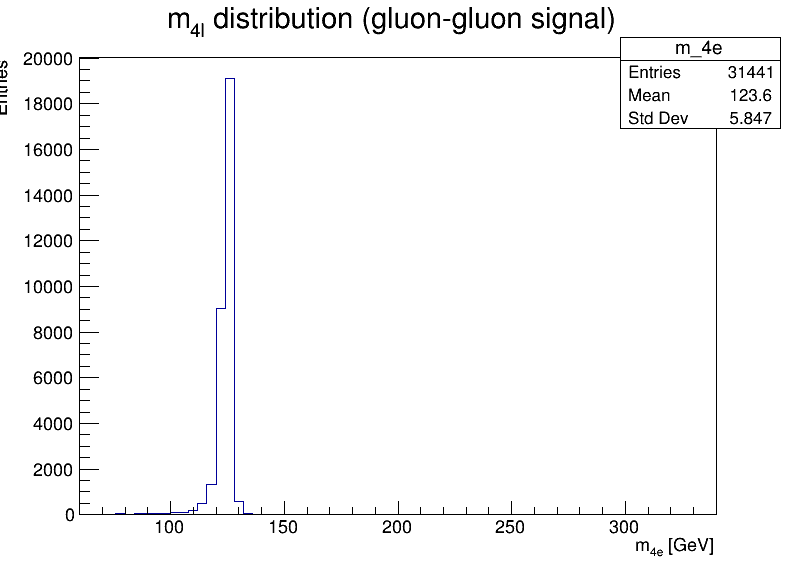

In [5]:
signal_gg = create_histogram('GluGluHToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root', 'Signal')

can1 = ROOT.TCanvas('can1', 'can1', 800, 600)
can1.cd()

signal_gg.SetTitle('m_{4l} distribution (gluon-gluon signal)')
signal_gg.Draw()
can1.Draw()

print(f'Mean is given as {signal_gg.GetMean()} GeV')

### c.)

In [6]:
%%time

signal_qq = create_histogram('VBF_HToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root', 'Signal')
bkg_gg_2e2mu = create_histogram('GluGluToContinToZZTo2e2mu_13TeV_MCFM701_pythia8.root', 'Background')
bkg_gg_4mu = create_histogram('GluGluToContinToZZTo4mu_13TeV_MCFM701_pythia8.root', 'Background')
bkg_gg_4e = create_histogram('GluGluToContinToZZTo4e_13TeV_MCFM701_pythia8.root', 'Background')
bkg_zz_1 = create_histogram('ZZTo4L_13TeV_powheg_pythia8.root', 'Background')
bkg_zz_2 = create_histogram('ZZTo4L_13TeV-amcatnloFXFX-pythia8.root', 'Background')

bkg_gg = bkg_gg_2e2mu.Clone()
bkg_gg.Add(bkg_gg_4mu)
bkg_gg.Add(bkg_gg_4mu)
out_gg = ROOT.TFile(f'histograms/hist_Backround_GluGluToContinToZZ.root','RECREATE')
out_gg.WriteObject(bkg_gg, 'bkg_gg')
# bkg_gg.Write()
bkg_gg_2e2mu.Write()
bkg_gg_4mu.Write()
bkg_gg_4mu.Write()
out_gg.Close()

bkg_zz = bkg_zz_1.Clone()
bkg_zz.Add(bkg_zz_2)
out_zz = ROOT.TFile(f'histograms/hist_Backround_ZZTo4L.root','RECREATE')
out_zz.WriteObject(bkg_zz, 'bkg_zz')
# bkg_zz.Write()
bkg_zz_1.Write()
bkg_zz_2.Write()
out_zz.Close()

Done
Done
Done
Done
Done
Done
CPU times: user 1min 1s, sys: 684 ms, total: 1min 2s
Wall time: 18.4 s


### d.)

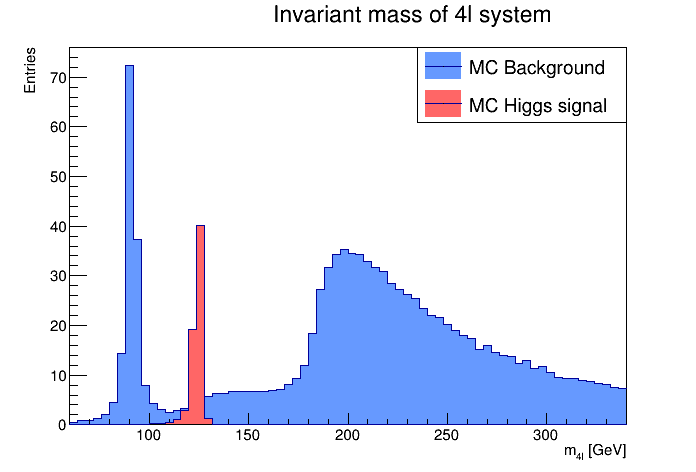

In [7]:
# Load Histograms (change paths accordingly)
f_qqToZZ = ROOT.TFile('histograms/hist_Backround_ZZTo4L.root', 'READ')
f_ggToZZ = ROOT.TFile('histograms/hist_Backround_GluGluToContinToZZ.root', 'READ')
f_ggToH = ROOT.TFile('histograms/hist_Signal_GluGluHToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root', 'READ')
f_qqToHqq = ROOT.TFile('histograms/hist_Signal_VBF_HToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root', 'READ')

# Initialize Final Histograms
signal = ROOT.TH1D('signal', 'MC Higgs signal', 70, 60, 340)
background = ROOT.TH1D('background', 'MC Background', 70, 60, 340)

# Add histograms and scale
signal.Add(f_ggToH.m_4l, f_qqToHqq.m_4l, .012180, .001044)
signal.Scale(66.3 / signal.GetEntries())
background.Add(f_qqToZZ.bkg_zz, f_ggToZZ.bkg_gg, 2.468, .01434)
background.Scale(1235.7 / background.GetEntries())
totSim = background.Integral() + signal.Integral()

#Canvas for MC comparison
can1 = ROOT.TCanvas('can1','MC Comparison')
background.SetFillColor(ROOT.kAzure-4)
background.Draw('hist')
signal.SetFillColor(ROOT.kRed-7)
signal.Draw('histsame')
ROOT.gStyle.SetOptStat(0)
leg1 = can1.BuildLegend(0.6,0.74,0.9,0.9)
leg1.Draw()
background.SetTitle('Invariant mass of 4l system;m_{4l} [GeV]; Entries')
can1.Draw()

From the background there is a sharp peak around $m_{z}$ and a broad peak above $2 m_{z}$ as expected ($m_{z}$ = 91.2 GeV) (theory detailed on page 125 in Data Analysis Manual).

From the signal there is peak around 120 GeV which is as we would want if we knew the Higgs boson to be of mass 125 GeV.

### e.)

In [8]:
higgs_data = create_histogram('Trimmed_Higgs_tree.root', 'Data')

Done


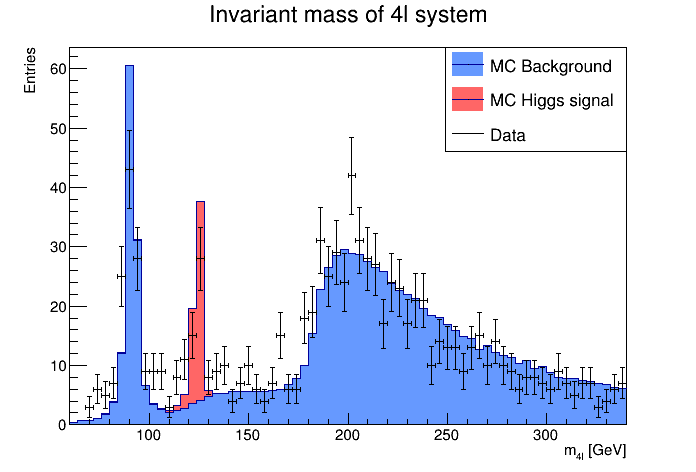

In [9]:
f_data = ROOT.TFile('histograms/hist_Data_Trimmed_Higgs_tree.root', 'READ')
totalMC = ROOT.THStack('totalMC','Combined MC')
background.Scale(f_data.m_4l.Integral()/totSim)
signal.Scale(f_data.m_4l.Integral()/totSim)
totalMC.Add(background)
totalMC.Add(signal)
can2 = ROOT.TCanvas('can2','MC-Data Comparison')
background.SetTitle('MC Background')
totalMC.Draw('fhist')
f_data.m_4l.SetTitle('Data')
f_data.m_4l.SetLineColor(ROOT.kBlack)
f_data.m_4l.Draw('e1same')
leg2 = can2.BuildLegend(0.64,0.68,0.9,0.9)
totalMC.SetTitle('Invariant mass of 4l system;m_{4l} [GeV]; Entries')
leg2.Draw()
can2.Draw()

The data seems to match well with the simulated predictions and follows the curves well. There is some potential overestimation on the number of entries around $m_{z}$ and some underestimation around $2 m_{z}$. There is also data to back the signal simulation which is a good sign that we have 'discovered' the Higgs boson as postulated!

### f.)

Suppose no Higgs boson, how many background events to de expect to see between 120 GeV and 128 GeV (postulated Higgs mass from previous experiments)?

In [10]:
bkg_exp_evt_no = background.Integral(16, 17)    # Is this bin number ??
print(bkg_exp_evt_no)

7.741057364879401


How many were actually measured in this reigon?

In [11]:
measured_evt_no = f_data.m_4l.Integral(16, 17)
print(measured_evt_no)

43.0


Simplified, we can assume that the number of events in the reigon is a poisson variable with mean, $\mu$, given by the expected number of background-only events in the reigon. This means the error is given by $\sqrt{\mu}$ (Poisson statistics).

From this what is the probability we get a value greater than or equal to our measurement? 

In [12]:
def poisson_dist(x, rate):
    
    return pow(rate, x) * math.exp(-rate)/math.factorial(x)

detection_prob = 0
for i in range(int(measured_evt_no), 100):                   # 100 should be large enough (roughly infinity)
    detection_prob += poisson_dist(i, bkg_exp_evt_no)

print(f'p value is: {detection_prob}')

p value is: 1.442028067878613e-18


Since this p-value is less than 0.0000003, we have discovered the Higgs boson!